<a href="https://colab.research.google.com/github/IcedRay/P6_Multiclass_NLP/blob/main/P6_02_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install nltk
!pip install umap
!pip install umap-learn

     |████████████████████████████████| 86 kB 2.6 MB/s 
     |████████████████████████████████| 1.1 MB 27.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=f42eeb0cd009f1cbb083791b31ce7619180c970b053b6065f235e1a056b896bd
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=e4575a5d15d1c5647359a8a45f28b579f9e707a30ee86af968273906b41ff573
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


# Methode non supervisée

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd
import numpy as np
df = pd.read_csv("/content/drive/MyDrive/cleanquestion.csv")

In [9]:
buff = df.values.tolist()
data = [[x[1],x[2],x[3][1:-1].split("><")]for x in buff]
data = [x for x in data if x[1] is not np.nan]

In [10]:
data[:5]

[['how convert decimal double c',
  'i want use change opacity this code c when i build application give following error none i tried using doesnt work this code worked fine past vbnet project',
  ['c#', 'floating-point', 'type-conversion', 'double', 'decimal']],
 ['why width collapse percentage width child element absolutely positioned parent internet explorer',
  'i absolutely positioned containing several child one relatively positioned when i use child collapse ie firefox safari if i use work if parent relatively positioned percentage width child work is something im missing is easy fix besides child is area cs specification cover',
  ['html', 'css', 'internet-explorer-7']],
 ['how i calculate someone age based datetime type birthday',
  'given representing person birthday i calculate age year',
  ['c#', '.net', 'datetime']],
 ['calculate relative time c',
  'given specific value i display relative time like hour ago day ago month ago',
  ['c#', 'datetime', 'time', 'datediff', 'rel

In [11]:
import random
random.seed(42)
random.shuffle(data)
train = data[4000:] #environ 20% sur ce dataset précisément
test =  data[:4000] #je pourrais utiliser une autre méthode pour la rendre insensible a la longueur en resmplaçant 4000 par int(POURCENTAGE*len(data)) avec POURCENTAGE le % que je souhaite en training

Algorithme pour chercher les meilleur hyper paramètre pour le TFID vecorizer,
on l'associe au MinibatchKmeans qui est un modèle assez général et très rapide pour trouver les meilleur hyperparamètre avant de commencer le training.

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import ShuffleSplit
Xpre_train = [x[1] for x in train]
pipeline = Pipeline([('count',CountVectorizer()) ,('vect', TfidfVectorizer(ngram_range=(1,3),stop_words = 'english')),('mbk', MiniBatchKMeans(init ='k-means++'))])
params = [{
    'vect__max_df':[0.01*x for x in range(1,99)],
    'vect__max_features':range(10,10000,10),
    'mbk__n_clusters':range(1,200),
    'mbk__n_init':range(3,50)
}]
cv=ShuffleSplit(test_size=0.20, n_splits=1,random_state=0)#pour retirer la cross validation
optimizer =HalvingRandomSearchCV(pipeline,params,n_jobs=-1,cv=cv)#.get_params().keys()#
optimizer.fit(Xpre_train)
optimizer.best_params_

In [14]:
import numpy as np

vect = TfidfVectorizer(ngram_range=(1,3),stop_words = 'english',max_df=0.78,max_features=207)
Xpre_train = [x[1] for x in train if x[1] is not np.nan]
vect.fit(Xpre_train)
X_t = vect.transform(Xpre_train)

In [15]:
import matplotlib
import umap
map = umap.UMAP()
X_train = map.fit_transform(X_t)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


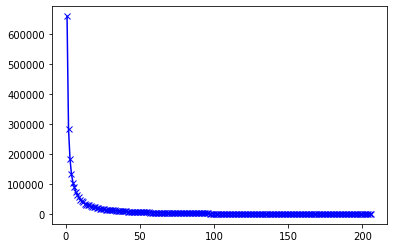

In [16]:
from sklearn.cluster import MiniBatchKMeans

sum_square_dist =[]
x = range(1,207)
for k in x:
  model = MiniBatchKMeans(n_clusters=k,n_init=10)
  model.fit(X_train)
  sum_square_dist.append(model.inertia_)
import matplotlib.pyplot as plt

plt.plot(x,sum_square_dist, 'bx-')
plt.show()

Pas de coude apparent, mais le modèle semble plus stabe après 50 et paraît être bon à 100 clusters

In [17]:
N_cluster = 50
model = MiniBatchKMeans(n_clusters=N_cluster,n_init=10)
y = model.fit_predict(X_train)

In [18]:
import operator
def addtag(tag,counter):
  if tag in counter.keys():
    counter[tag] +=1
  else:
    counter[tag] = 1
tag_list = []
avg = []
for i in range(N_cluster):
  c = {'default_never_used':0}
  a = []
  for i_sentence in range(len(train)):
    if y[i_sentence]==i:
      a.append(len(train[i_sentence][2]))
      for tag in train[i_sentence][2]:
        addtag(tag,c)
  avg.append(sum(a)/len(a))
  tag_list.append(sorted(c.items(), key=lambda x: x[1], reverse=True))

for i in range(len(tag_list)):
  print("cluster n : ",i)
  print("Moyenne du nombre de tags dans le cluster :",avg[i])
  print("Tags : ",tag_list[i][:round(avg[i])])
print('nbr de tag moyen = ', avg)

cluster n :  0
Moyenne du nombre de tags dans le cluster : 3.041095890410959
Tags :  [('image', 55), ('.net', 30), ('c#', 28)]
cluster n :  1
Moyenne du nombre de tags dans le cluster : 2.892123287671233
Tags :  [('.net', 59), ('c#', 56), ('java', 44)]
cluster n :  2
Moyenne du nombre de tags dans le cluster : 2.8256880733944953
Tags :  [('c++', 51), ('c#', 36), ('c', 30)]
cluster n :  3
Moyenne du nombre de tags dans le cluster : 2.94
Tags :  [('64-bit', 37), ('c#', 29), ('c++', 27)]
cluster n :  4
Moyenne du nombre de tags dans le cluster : 2.8993576017130622
Tags :  [('database', 82), ('sql-server', 47), ('c#', 39)]
cluster n :  5
Moyenne du nombre de tags dans le cluster : 2.8835403726708075
Tags :  [('c#', 62), ('java', 56), ('windows', 55)]
cluster n :  6
Moyenne du nombre de tags dans le cluster : 2.993205682520074
Tags :  [('c#', 188), ('.net', 166), ('java', 126)]
cluster n :  7
Moyenne du nombre de tags dans le cluster : 2.9554794520547945
Tags :  [('c#', 110), ('.net', 91), 

In [19]:
[key for key,value in tag_list[0][:round(avg[0])]]

['image', '.net', 'c#']

In [ ]:
from io import StringIO
from html.parser import HTMLParser
import re
import pickle
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

from io import StringIO
from html.parser import HTMLParser
import re
class MLStripper(HTMLParser):
  def __init__(self):
    super().__init__()
    self.reset()
    self.strict = False
    self.convert_charrefs= True
    self.text = StringIO()
  def handle_data(self, d):
    self.text.write(d)
  def get_data(self):
    return self.text.getvalue()

def strip_tags(html):
  noescape = re.sub('\n',' ',html)
  nocode = re.sub('<code*?.*?/code>','',noescape)# on retire le code
  explicit1 = re.sub('<pre class="lang-',' ',nocode)# on garde le tag de language
  explicit2 = re.sub('prettyprint-override">','',explicit1)# on garde le tag de language
  explicit3 = re.sub('</pre>','',explicit2)
  s = MLStripper()
  s.feed(explicit3)
  return s.get_data()

def preprocess(sentence):
  stemmer = WordNetLemmatizer()
  nopunc = [char for char in sentence if char not in string.punctuation]
  nopunc_nodigit = ''.join([i for i in nopunc if not i.isdigit()])
  stopworded = [word.lower() for word in nopunc_nodigit.split() if word not in stopwords.words('english')]
  return [stemmer.lemmatize(word) for word in stopworded]

def clean(txt):
  return " ".join(preprocess(strip_tags(txt)))

class Tagger:
  def __init__(self,avg,tag,mod,vec):
    self.average = avg
    self.tags = tag
    self.model = mod
    self.vectorizer = vec
  def get_tags(self,value):
    return  [key for key,value in self.tags[i][:round(avg[i])]]
  def get_cluster(self,txt):
    buff = vect.transform([clean(txt)])
    return model.predict(buff)[0]
savetags = Tagger(avg,tag_list,model,vect)
with open("/content/drive/MyDrive/savetags.savtag","wb+") as f:
    pickle.dump(savetags, f)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
with open("/content/drive/MyDrive/savetags.savtag","rb") as f:
  tagger = pickle.load(f)
tagger.get_tags(tagger.get_cluster(test[3099][1]))


['c++', 'java', '.net']

# Methode supervisée
